# Infer building instances with a Mask-RCNN model

In [66]:
import collections
import cv2
import geojson
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from osgeo import gdal, osr
import pandas as pd
from PIL import Image
import shapely.geometry as shgeom
import shapely.wkt as swkt

from mrcnn import model as modellib
from mrcnn.config import Config
from mrcnn import visualize

%matplotlib inline

In [2]:
from tanzania_challenge import buildings

## Dataset configuration setting

In [3]:
class BuildingConfig(Config):
    NAME = "building"
    NUM_CLASSES = 1 + 3
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

In [4]:
config = BuildingConfig()

## Model loading

In [5]:
model_dir = os.path.join("..", "data", "open_ai_tanzania", "output", "instance_segmentation", "checkpoints")
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=model_dir)

In [6]:
weights_path = model.find_last() ; print(weights_path)
model.load_weights(weights_path, by_name=True)

../data/open_ai_tanzania/output/instance_segmentation/checkpoints/buildings20181019T1148/mask_rcnn_buildings_0015.h5
Re-starting from epoch 15


## Dataset declaration

In [7]:
test_bd = buildings.BuildingDataset()
test_bd.load_buildings(os.path.join("..", "data", "open_ai_tanzania", "preprocessed"),
                       subset="testing", img_size=config.IMAGE_MIN_DIM)
test_bd.prepare()

In [8]:
nb_images = len(test_bd.image_info)

In [9]:
test_bd.num_images

62220

In [10]:
import time

for image_id in test_bd.image_ids[:1]:
    a = time.time()
    image = test_bd.load_image(image_id)
    print(np.expand_dims(image, 0).shape)
    prediction = model.detect(np.expand_dims(image, 0))
    print(prediction[0]["class_ids"])
    b = time.time()
    print(b-a)

(1, 221, 267, 3)
[1 1 1 1 1]
5.360593557357788


## Image inference

In [68]:
image_path = os.path.join("..", "data", "open_ai_tanzania", "preprocessed", "384", "testing", "images")
feature_path = os.path.join("..", "data", "open_ai_tanzania", "preprocessed", "384", "testing", "features")
prediction_path = os.path.join("..", "data", "open_ai_tanzania", "preprocessed", "384", "testing", "predicted_bkp")
geom_path = os.path.join("..", "data", "open_ai_tanzania", "preprocessed", "384", "testing", "geo_predictions")

### Named image

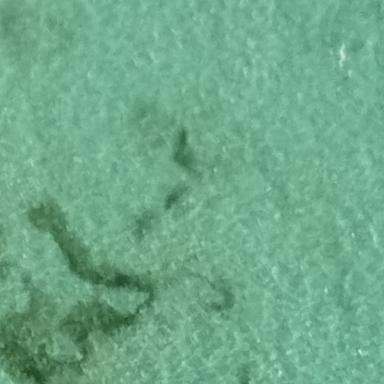

In [12]:
filename = "5ae36dd70b093000130afdbb_384_384_26112_42624.tif"
im = Image.open(os.path.join(image_path, filename)) ; im

### Random image

5ae318220b093000130afd99_384_384_16896_14976.tif


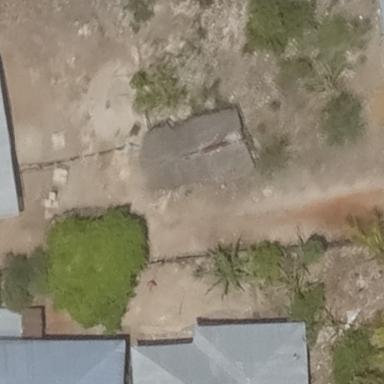

In [42]:
filename = np.random.choice(os.listdir(image_path)) ; print(filename)
im = Image.open(os.path.join(image_path, filename)) ; im

### Prediction

In [43]:
prediction = model.detect(np.expand_dims(np.array(im), 0))

In [44]:
p = prediction[0]
p["rois"], p["class_ids"], p["scores"]

(array([[316,  14, 381, 249],
        [ 45,   0, 231,  21],
        [ 36,   0, 309,  48]], dtype=int32),
 array([1, 1, 1], dtype=int32),
 array([0.82814574, 0.8088175 , 0.7695953 ], dtype=float32))

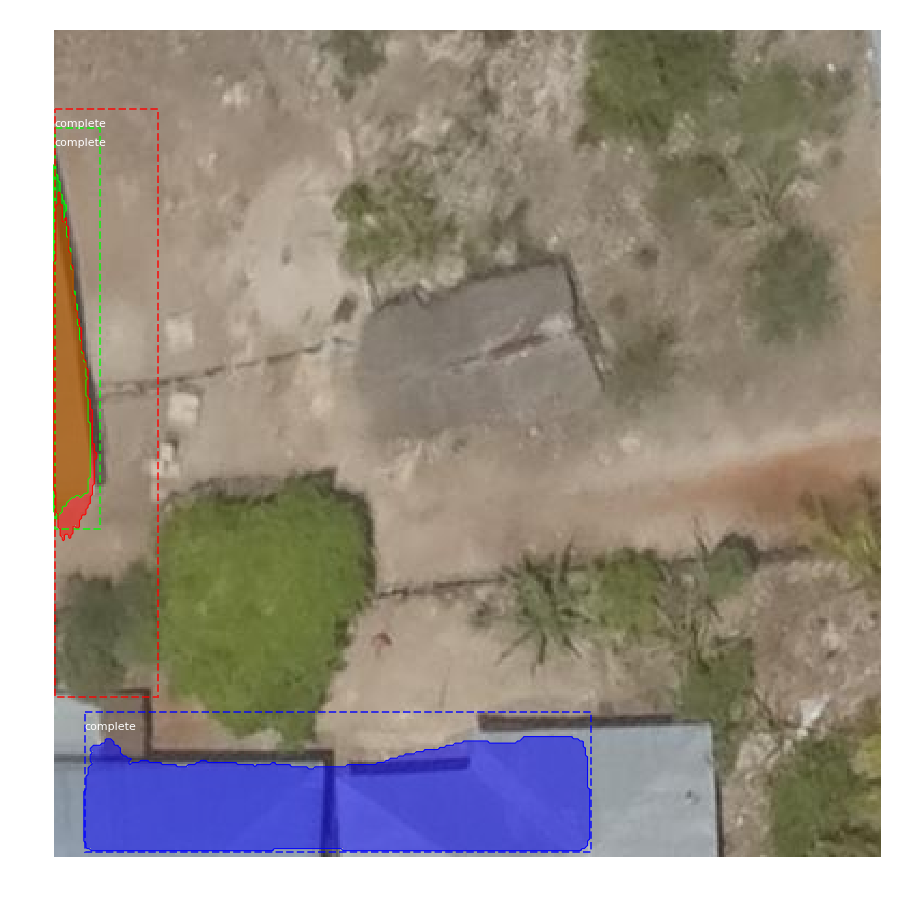

In [45]:
visualize.display_instances(np.array(im),
                            p["rois"],
                            p["masks"],
                            p["class_ids"],
                            ["", "complete", "incomplete", "foundation"],
                           show_mask=True)

In [46]:
result = {"masks": np.moveaxis(p["masks"], 2, 0).tolist(),
         "class_ids": p["class_ids"].tolist(),
         "scores": p["scores"].tolist()}
with open(os.path.join(prediction_path, filename.replace(".tif", ".json")), "w") as f:
    json.dump(result, f)

## Post-processing

### Utility

In [71]:
def pixel_to_coordinates(x, y, imfeatures):
    lat = int(imfeatures["west"] + (imfeatures["east"]-imfeatures["west"]) * x / imfeatures["width"])
    lon = int(imfeatures["north"] + (imfeatures["south"]-imfeatures["north"]) * y / imfeatures["height"])
    return lat, lon

In [56]:
def set_coordinates_as_x_y(lat, lon, srid):
    source = osr.SpatialReference()
    source.ImportFromEPSG(srid)
    target = osr.SpatialReference()
    target.ImportFromEPSG(4326)
    transform = osr.CoordinateTransformation(source, target)
    x, y = transform.TransformPoint(lat, lon)[:2]
    return x, y


In [33]:
def pixel_to_latlon(x, y, imfeatures):
    coordinates = pixel_to_coordinates(x, y, imfeatures)
    return set_coordinates_as_x_y(coordinates[0], coordinates[1], imfeatures["srid"])

In [34]:
def build_geom(building, imfeatures=None, pixel=False, min_x=2500, min_y=2500):
    feature = []
    for point in building:
        if pixel:
            feature.append((int(min_x + point[0][0]), min_y + int(point[0][1])))
        else:
            feature.append(pixel_to_latlon(point[0][0], point[0][1], imfeatures))
    feature.append(feature[0])
    return feature

In [35]:
def add_polygon(polygon, class_id, score, results, geofeatures, min_x=0, min_y=0):
    """
    """
    feature = build_geom(polygon, imfeatures=geofeatures, pixel=False, min_x=min_x, min_y=min_y)
    geom = geojson.Polygon([feature])
    shape = shgeom.shape(geom)
    pixel_feature = build_geom(polygon, pixel=True, min_x=0, min_y=0)
    pixel_geom = geojson.Polygon([pixel_feature])
    pixel_shape = shgeom.shape(pixel_geom)
    predictions = np.zeros([3])
    predictions[class_id-1] = score
    return results.append([*predictions, shape.wkt, pixel_shape.wkt])

In [197]:
def extract_geometry(mask, structure):
    """
    """
    denoised = cv2.morphologyEx(mask, cv2.MORPH_OPEN, structure)
    grown = cv2.morphologyEx(denoised, cv2.MORPH_CLOSE, structure)
    _, contours, _ = cv2.findContours(grown, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    polygons = [cv2.approxPolyDP(c, epsilon=0.005*cv2.arcLength(c, closed=True), closed=True)
                for c in contours]
    return polygons

### Post-process the random image

In [154]:
with open(os.path.join(feature_path, filename.replace(".tif", ".json"))) as f:
    features = json.load(f)
with open(os.path.join(prediction_path, filename.replace(".tif", ".json"))) as f:
    prediction = json.load(f)

In [155]:
masks = np.array(prediction["masks"], dtype=np.uint8)
class_ids = np.array(prediction["class_ids"], dtype=np.int8)
scores = np.array(prediction["scores"], dtype=np.float32)

In [198]:
results = []
structure = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
_, _, _, min_x, min_y = filename.split(".")[0].split("_")
for mask, class_id, score in zip(masks, class_ids, scores):
    polygon = extract_geometry(mask, structure)
    for p in polygon:
        add_polygon(p, class_id, score, results, features, min_x=min_x, min_y=min_y)

In [199]:
df = pd.DataFrame(results, columns=["conf_completed", "conf_incompleted", "conf_foundation", "coords_geo", "coords_pixel"])
df

,conf_completed,conf_incompleted,conf_foundation,coords_geo,coords_pixel
0,0.828146,0.0,0.0,"POLYGON ((39.37857292179137 -5.99674307161162,...","POLYGON ((247 337, 240 328, 190 330, 149 341, ..."
1,0.808818,0.0,0.0,POLYGON ((39.37842823266657 -5.996571295156365...,"POLYGON ((0 66, 0 223, 2 224, 8 216, 15 213, 1..."
2,0.769595,0.0,0.0,POLYGON ((39.37842823890126 -5.996580341279954...,"POLYGON ((2 80, 0 82, 0 222, 3 233, 7 234, 16 ..."


### Geolocalize the results

In [200]:
df["geom"] = [swkt.loads(s) for s in df["coords_geo"]]

In [201]:
gdf = gpd.GeoDataFrame(df, geometry="geom")

In [202]:
rm ../data/open_ai_tanzania/preprocessed/384/testing/geo_predictions/5ae318220b093000130afd99_384_384_16896_14976.geojson

In [203]:
gdf.to_file(os.path.join(geom_path, filename.replace(".tif", ".geojson")), driver="GeoJSON")